In [1]:
import numpy as np
import suite2p
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Dict, Any
from scipy.stats import kde, pearsonr
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import find_peaks
import cottage_analysis as cott
from cottage_analysis.imaging.common import align_timestamps, find_frames


# Suite2p visualization

## Filepath

In [2]:
# filepath
rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'
project = 'hey2_3d-vision_20210716'
data_dir = ''
mouse = 'PZAH2.1b'
session = 'S20210916'
recording = 'R163430'
protocol = 'SphereSparseNoise'
suite2p_dir = 'suite2p_rois_0/suite2p/plane0/'
trace_dir = 'suite2p_traces_0'

def generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol):
    rawdata_folder = rawdata_root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    preprocess_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    analysis_folder = root + project + '/' + data_dir + 'Analysis/' + mouse + '/' + session + '/' + recording + '_' + protocol +'/'
    
    return rawdata_folder, preprocess_folder, analysis_folder

def generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir):
    suite2p_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + suite2p_dir
    trace_folder = root + project + '/' + data_dir + mouse + '/' + session + '/' + recording + '_' + protocol +'/' +  protocol + '_' + trace_dir
    
    return suite2p_folder, trace_folder


rawdata_folder, preprocess_folder, analysis_folder = generate_filefolder(root, rawdata_root, project, data_dir, mouse, session, recording, protocol)
print(rawdata_folder, preprocess_folder, analysis_folder)

suite2p_folder, trace_folder = generate_suite2p_folder(root, project, data_dir, mouse, session, recording, protocol, suite2p_dir, trace_dir)
print(suite2p_folder, trace_folder)

if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

    

/camp/lab/znamenskiyp/data/instruments/raw_data/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/Analysis/PZAH2.1b/S20210916/R163430_SphereSparseNoise/
/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/suite2p_rois_0/suite2p/plane0/ /camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/R163430_SphereSparseNoise/SphereSparseNoise_suite2p_traces_0


## Load files

In [3]:
# Load files
F = np.load(suite2p_folder+'F.npy', allow_pickle=True)
Fneu = np.load(suite2p_folder+'Fneu.npy', allow_pickle=True)
spks = np.load(suite2p_folder+'spks.npy', allow_pickle=True)
stat = np.load(suite2p_folder+'stat.npy', allow_pickle=True)
ops =  np.load(suite2p_folder+'ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(suite2p_folder+'iscell.npy', allow_pickle=True)
output_op = ops

In [4]:
ops

{'look_one_level_down': False,
 'fast_disk': '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/suite2p_rois_0/suite2p/plane0',
 'delete_bin': False,
 'mesoscan': False,
 'bruker': False,
 'h5py': [],
 'h5py_key': 'data',
 'save_path0': '/camp/lab/znamenskiyp/home/shared/projects/hey2_3d-vision_20210716/PZAH2.1b/S20210916/suite2p_rois_0',
 'save_folder': 'suite2p',
 'subfolders': [],
 'move_bin': False,
 'nplanes': 1,
 'nchannels': 1,
 'functional_chan': 1,
 'tau': 0.7,
 'fs': 29.9814,
 'force_sktiff': False,
 'frames_include': -1,
 'multiplane_parallel': False,
 'ignore_flyback': [],
 'preclassify': 0.0,
 'save_mat': False,
 'save_NWB': False,
 'combined': True,
 'aspect': 1.0,
 'do_bidiphase': False,
 'bidiphase': 0,
 'bidi_corrected': True,
 'do_registration': 1,
 'two_step_registration': False,
 'keep_movie_raw': False,
 'nimg_init': 300,
 'batch_size': 500,
 'maxregshift': 0.1,
 'align_by_chan': 1,
 'reg_tif': False,
 'reg_tif_chan2': False,
 's

In [7]:
len(iscell[iscell==True])

256

## Registration

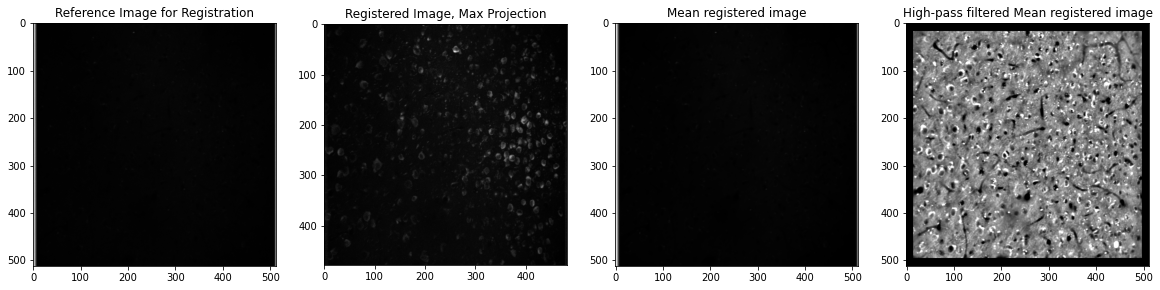

In [8]:
# Registration
plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.imshow(output_op['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(output_op['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_op['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_op['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

## Detection

In [9]:
# Detection
stats_file = Path(output_op['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_op['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((359,), (359,))

In [10]:
# Make an array for ROI mask for each ROI
def stats_to_array(stats: Sequence[Dict[str, Any]], Ly: int, Lx: int, label_id: bool = False):
    """
    converts stats sequence of dictionaries to an array
    :param stats: sequence of dictionaries from stat.npy
    :param Ly: number of pixels along dim Y from ops dictionary
    :param Lx: number of pixels along dim X
    :param label_id: keeps ROI indexing
    :return: numpy stack of arrays, each containing x and y pixels for each ROI
    """
    arrays = []
    for i, stat in enumerate(stats):
        arr = np.zeros((Ly, Lx), dtype=float)
        arr[stat['ypix'], stat['xpix']] = 1
        if label_id:
            arr *= i + 1
        arrays.append(arr)
    return(np.stack(arrays))

stats_arr = stats_to_array(stats, ops['Ly'], ops['Lx'])
stats_arr.shape

(359, 512, 512)

<ipython-input-11-ef6b5dd464b6>:22: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im, axis=0), cmap='jet')
<ipython-input-11-ef6b5dd464b6>:26: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[~iscell], axis=0), cmap='jet')
<ipython-input-11-ef6b5dd464b6>:30: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')


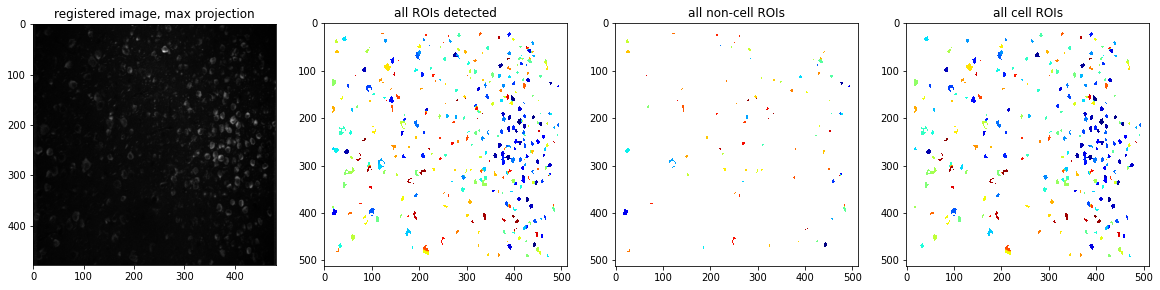

In [11]:
def plot_detection_outcome(stats, ops, iscell, fname=None, output_dir=None):
    """
    generates a four panel plot with maximum intensity projection, both cell and non-cell ROIs
    detected in recording, all non-cell ROIs and all cell ROIs
    :param stats: stats array from stat.npy
    :param ops: dictionary of suite2p settings
    :param iscell: boolean array of which ROIs are identified as cells
    :param fname: name of recording for writing plots to file
    :param output_dir: path to directory for writing plots to file
    :return: none
    """
    im = stats_to_array(stats, Ly = ops['Ly'], Lx = ops['Lx'], label_id=True)
    im[im == 0] = np.nan

    plt.ioff()
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    plt.subplot(1, 4, 1)
    plt.imshow(ops['max_proj'], cmap='gray')
    plt.title("registered image, max projection");

    plt.subplot(1, 4, 2)
    plt.imshow(np.nanmax(im, axis=0), cmap='jet')
    plt.title("all ROIs detected");

    plt.subplot(1, 4, 3)
    plt.imshow(np.nanmax(im[~iscell], axis=0), cmap='jet')
    plt.title("all non-cell ROIs");

    plt.subplot(1, 4, 4)
    plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
    plt.title("all cell ROIs");

    if (fname!=None) and (output_dir!=None):
        fig_name = Path(output_dir).joinpath("%s_cell-detect-outcomes.svg"%fname)

        fig.savefig(fig_name, format="svg", dpi=1200)
        plt.close(fig)


plot_detection_outcome(stats, ops, iscell)

## Extract Traces

In [9]:
f_cells = np.load(Path(output_op['save_path']).joinpath('F.npy'))
f_neus = np.load(Path(output_op['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_op['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neus.shape, spks.shape

((359, 218389), (359, 218389), (359, 218389))

In [12]:
f_cells = np.load(Path(trace_folder).joinpath('F.npy'))
f_neus = np.load(Path(trace_folder).joinpath('Fneu.npy'))
spks = np.load(Path(trace_folder).joinpath('spks.npy'))
f_cells.shape, f_neus.shape, spks.shape

((359, 184409), (359, 184409), (359, 184409))

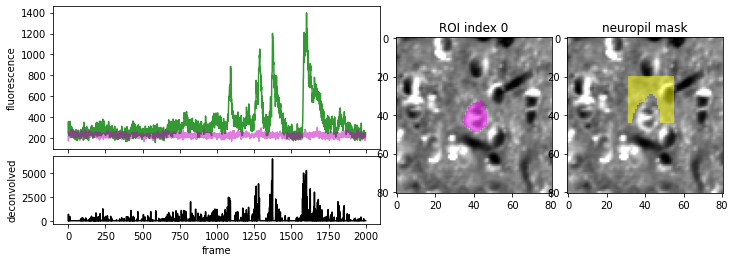

In [13]:
# Visualize one roi and its neuropil

def make_bounding_box(stat):
    """
    utility function for creating a bounding box around cells and neuropil masks
    :param stat: numpy array from stat.npy
    :returns y_lim1, y_lim2, x_lim1, x_lim2: x and y pixels for adding ~ 40 px border around cell ROI or mask
    """
    y_min = stat['ypix'].min()
    y_max = stat['ypix'].max()

    x_min = stat['xpix'].min()
    x_max = stat['xpix'].max()

    y_pad = round((80 - np.ptp(stat['ypix'])) / 2)
    x_pad = round((80 - np.ptp(stat['xpix'])) / 2)

    y_lim1 = y_min - y_pad
    y_lim2 = y_max + y_pad

    x_lim1 = x_min - x_pad
    x_lim2 = x_max + x_pad

    return y_lim1, y_lim2, x_lim1, x_lim2

def plot_roi_and_neuropil(f, f_neu, spks, ops, stat, which_roi, plot_start=0, plot_stop=f_cells.shape[1], fname=None, out_dir=None):
    """
    utility for generating a multipanel plot by user-selected ROI. plots
    fluoresence trace, neuropil fluo trace, deconvolved spikes, cell ROI and
    neuropil mask. f, f_neu and spks are only plotted for first 2000 frames
    :param f: numpy array of fluorescence values
    :param f_neu: numpy array of neuropil fluorescence values
    :param spks: numpy array of deconvolved spikes
    :param ops: dictionary of suite2p settings
    :param stat: numpy array of stat.npy
    :param which_roi: index of ROI to be plotted
    :param fname: string containing name of recording for writing figure to file
    :param out_dir: path to write .svg files
    :return: none
    """
    im = stats_to_array(stat, Ly=ops['Ly'], Lx=ops['Lx'], label_id=True)
    im[im == 0] = np.nan

    fig = plt.figure(figsize=(12, 4))
    grid = plt.GridSpec(3, 4, wspace=0.1, hspace=0.1, figure=fig)

    f_ax = fig.add_subplot(grid[0:2, 0:2])
    f_ax.plot(range(plot_start, plot_stop, 1), f[which_roi, range(plot_start, plot_stop, 1)], 'g', alpha=0.8)
    f_ax.plot(range(plot_start, plot_stop,1), f_neu[which_roi, range(plot_start, plot_stop,1)], 'm', alpha=0.5)
    f_ax.set_ylabel('fluorescence')

    # Adjust spks range to match range of fluorescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin
    sp = spks[which_roi,]
    sp /= sp.max()
    sp *= frange
    sp = sp[range(plot_start, plot_stop,1)]

    spks_ax = fig.add_subplot(grid[2, 0:2])
    spks_ax.plot(range(plot_start, plot_stop,1), sp, 'k')
    spks_ax.set_xlabel('frame')
    spks_ax.set_ylabel('deconvolved')

    # Calculate bounding box for visualising ROI overlaid on meanImgE (consider writing as its own function)
    s = stat[which_roi]
    y_lim1, y_lim2, x_lim1, x_lim2 = make_bounding_box(s)

    img_ax = fig.add_subplot(grid[:, 2])
    img_ax.imshow(ops['meanImgE'][y_lim1:y_lim2, x_lim1:x_lim2], cmap='gray')
    img_ax.imshow(im[which_roi, y_lim1:y_lim2, x_lim1:x_lim2], alpha=0.5, cmap='spring')
    img_ax.title.set_text('ROI index %s'%(which_roi))

    cell_pix=np.zeros((ops['Ly'], ops['Lx']))
    lammap=np.zeros((ops['Ly'], ops['Lx']))
    ypix=s['ypix']
    xpix=s['xpix']
    lam=s['lam']
    lammap[ypix, xpix] = np.maximum(lammap[ypix, xpix], lam)
    cell_pix = lammap > 0.0

    mask=suite2p.extraction.create_neuropil_masks(
        ypixs=s['ypix'],
        xpixs=s['xpix'],
        cell_pix=cell_pix,
        inner_neuropil_radius=ops['inner_neuropil_radius'],
        min_neuropil_pixels=ops['min_neuropil_pixels'],
        circular=ops.get('circular_neuropil', False)
    )

    neu_mask = np.zeros(512*512)
    neu_mask[mask[0]] = 1
    # check that pixels are being mapped back to 2D array correctly
    neu_mask = np.reshape(neu_mask, (512,512))
    neu_mask[neu_mask == 0] = np.nan

    mask_ax = fig.add_subplot(grid[:, 3])
    mask_ax.imshow(ops['meanImgE'][y_lim1:y_lim2, x_lim1:x_lim2], cmap='gray')
    mask_ax.imshow(neu_mask[y_lim1:y_lim2, x_lim1:x_lim2], cmap=plt.cm.get_cmap('spring').reversed(), alpha=0.5)
    mask_ax.title.set_text('neuropil mask')

    if (fname!=None) and (output_dir!=None):
        # fix potential errors if trailing slash is not included
        basename = fname + "_f-cell-neuropil_roi%s.svg"%which_roi
        fig_name = Path(out_dir).joinpath(basename)

        fig.savefig(fig_name, format="svg", dpi=1200)
        plt.close(fig)

# add function for plotting f vs f_neu for ROI of interest
def plot_f_f_neu(f, f_neu, which_roi, fname=None, out_dir=None):
    """
    a function that plots f vs f_neu for user-selected ROI, displays as a colour map of the KDE
    :param f: numpy array of cell fluorescence values
    :param f_neu: numpy array of neuropil fluorescence values
    :param which_roi: index of ROI
    :param fname: str, name of recording for writing figure to file
    :param out_dir: str, path to directory for writing .svg files
    :return: none
    """
    x = f[which_roi,:]
    y = f_neu[which_roi,:]
    # calculate Pearson's R from cell and neuropil fluorescence
    corr, _ = pearsonr(x, y)

    # create a gaussian KDE on a regular grid of 256 x 256 bins
    nbins = 256
    k = kde.gaussian_kde([x, y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # make a figure of cell and neuropil fluorescence values, density
    # of points
    fig = plt.figure(figsize=(4,4))
    ax = fig.gca()

    ax.tick_params(axis='y', left=True, which='major', labelleft=True)
    czset = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='Greens')
    cset = ax.contour(xi, yi, zi.reshape(xi.shape), colors='k')

    ax.clabel(cset, inline=1, fontsize=8)
    ax.set_xlabel('cell fluorescence')
    ax.set_ylabel('neuropil fluorescence')
    ax.set_title('ROI index %s'%which_roi)
    ax.text(0.1, 0.9, 'Pearson\'s R = %3f'%corr,
            verticalalignment='bottom',
            horizontalalignment='left',
            transform=ax.transAxes)

    if (fname!=None) and (output_dir!=None):
        basename = fname + "_f-cell-neuropil-corr_roi%s.svg" % which_roi
        fig_name = Path(out_dir).joinpath(basename)

        fig.savefig(fig_name, format="svg", dpi=1200)
        plt.close(fig)
        
        
plot_roi_and_neuropil(F, Fneu, spks, ops, stats, which_roi=0, plot_start=0, plot_stop=2000)

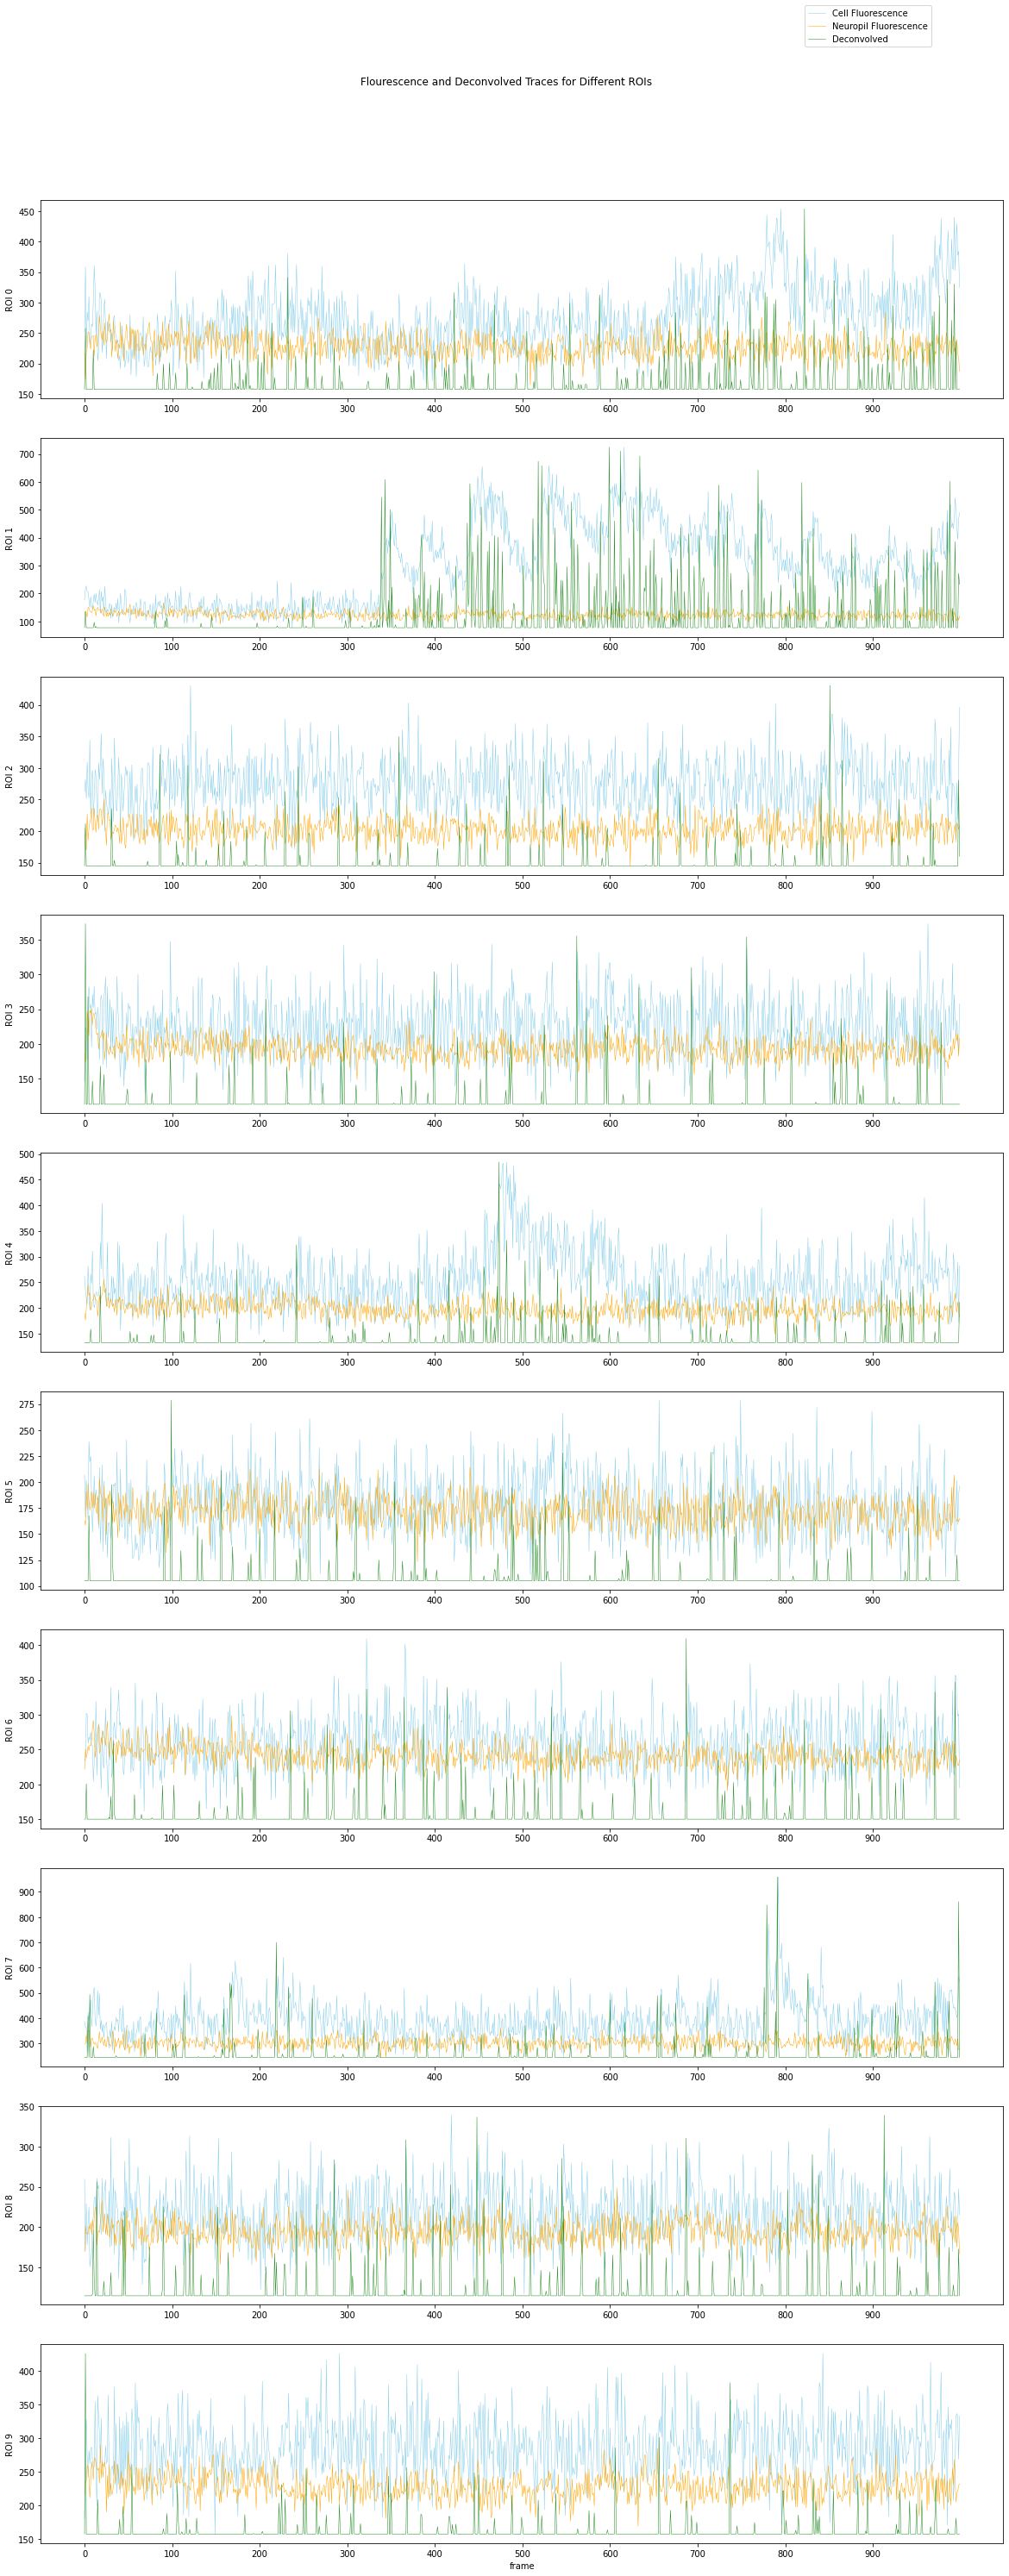

In [14]:
# Plot selected roi traces in a certain time frame
def plot_roi_trace(f_cells, f_neus, spks, which_rois, plot_start=0, plot_end=f_cells.shape[1], enable_fcells=True, enable_fneus=True, enable_spks=True, lw=0.5, colors=['skyblue','orange','forestgreen']):

    plt.figure(figsize=[20,5*len(which_rois)])
    plt.suptitle("Flourescence and Deconvolved Traces for Different ROIs", y=0.92);
    for i, roi in enumerate(which_rois):
        plt.subplot(len(which_rois), 1, i+1, )
        f = f_cells[roi][plot_start:plot_end]
        f_neu = f_neus[roi][plot_start:plot_end]
        sp = spks[roi][plot_start:plot_end]
        # Adjust spks range to match range of fluroescence traces
        fmax = np.maximum(f.max(), f_neu.max())
        fmin = np.minimum(f.min(), f_neu.min())
        frange = fmax - fmin 
        sp /= sp.max()
        sp *= frange
        if enable_fcells:
            plt.plot(f, label="Cell Fluorescence", color = colors[0], linewidth=lw)
        if enable_fneus:
            plt.plot(f_neu, label="Neuropil Fluorescence", color = colors[1], linewidth=lw)
        if enable_spks:
            plt.plot(sp + fmin, label="Deconvolved", color = colors[2], linewidth=lw)
        plt.xticks(np.arange(0, len(f), len(f)/10))
        plt.ylabel(f"ROI {roi}", rotation=90)
        if i == 0:
            plt.legend(bbox_to_anchor=(0.93, 2))
    plt.xlabel("frame")

which_rois = np.arange(10)
plot_roi_trace(f_cells, f_neus, spks, which_rois, plot_start=0, plot_end=1000, enable_fcells=True, enable_fneus=True, enable_spks=True, colors=['skyblue','orange','forestgreen'])

# Process vis-stim loggers & harp

## Load & Format files & Synchronization

In [15]:
# Filepath 
def generate_rawdata_prefix(session, recording, protocol):
    return (mouse+'_'+session+'_'+recording+'_'+protocol)

rawdata_prefix = generate_rawdata_prefix(session, recording, protocol)
photodiode_file = rawdata_folder + rawdata_prefix + '_' + 'PhotodiodeLog.csv'
rotary_encoder_file = rawdata_folder + rawdata_prefix + '_' + 'RotaryEncoder.csv'
harpmessage_file = rawdata_folder + rawdata_prefix + '_' + 'harpmessage.csv'
paramlog_file = rawdata_folder + rawdata_prefix + '_' + 'NewParams.csv'

/camp/home/hey2/.conda/envs/2p_analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


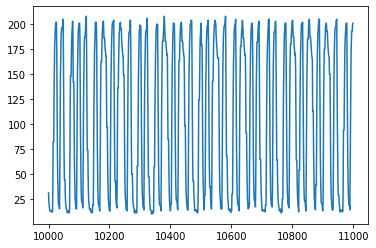

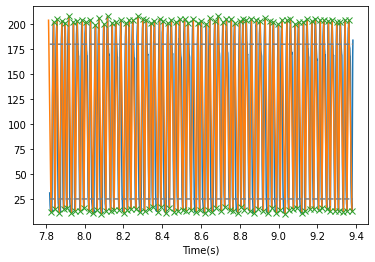

In [16]:
# Find vis-stim frames
def format_VS_photodiode_logger(VS_photodiode_logger):
    '''
    Format dataframe for VisStim frame_logger
    df columns = 'HarpTime','ElapsedTime'
    Parameters
    ----------
    VS_frame_logger : Dataframe
        Loaded dataframe from VS frame_logger.csv
    Returns
    -------
    formatted_df : Dataframe
        Formatted dataframe for VS_frame_logger
    '''
    formatted_df = pd.DataFrame(columns=['HarpTime', 'Photodiode'])
    formatted_df['HarpTime'] = VS_photodiode_logger['HarpTime']
    formatted_df['Photodiode'] = VS_photodiode_logger['Photodiode']

    formatted_df['ElapsedTime'] = VS_photodiode_logger['HarpTime'] - VS_photodiode_logger.loc[0, 'HarpTime']

    # Returns
    return formatted_df
VS_photodiode_logger = pd.read_csv(photodiode_file, sep=',')
VS_photodiode_logger = format_VS_photodiode_logger(VS_photodiode_logger)
plt.plot(VS_photodiode_logger['Photodiode'][10000:11000])
VS_photodiode_logger  = find_frames.find_VS_frames(photodiode_df=VS_photodiode_logger, frame_rate=144, upper_thr=180, lower_thr=25, plot=True, plot_start=10000, plot_range=2000, plot_dir=None)


In [17]:
# Load params
def format_VS_param_logger(VS_param_logger, which_protocol):
    '''
    Format dataframe for VisStim param_logger
    df columns = 'HarpTime','ElapsedTime' (calculated from the start of frame logger!!), Params...
    
    Parameters
    ----------
    VS_param_logger : Dataframe
        Loaded dataframe from VS param_logger.csv
    VS_frame_logger : Dataframe
        Loaded dataframe from VS frame_logger.csv
    which_protocol: string
        The Vis-Stim protocol used ('Retinotopic','Fourier')
    Returns
    -------
    formatted_df : Dataframe
        Formatted dataframe for VS_param_logger. !!ElapsedTime is already alighed to the starting of the frame logger
    '''
    formatted_df = pd.DataFrame(columns=['HarpTime'])

    formatted_df['HarpTime'] =  VS_param_logger['HarpTime']
    #formatted_df['ElapsedTime'] = VS_param_logger['HarpTime'] - VS_frame_logger.loc[0,'HarpTime']
    
    # Assign params according to stimulation protocol 
    if which_protocol == 'Retinotopy':
        formatted_df['Xdeg'] =  VS_param_logger['Xdeg']   
        formatted_df['Ydeg'] =  VS_param_logger['Ydeg']   
        formatted_df['Angle'] =  VS_param_logger['Angle']
        
    elif which_protocol == 'Fourier':
        formatted_df['BarID'] =  VS_param_logger['BarID']   
        formatted_df['LocationX'] =  VS_param_logger['LocationX']   
        formatted_df['LocationY'] =  VS_param_logger['LocationY'] 
        formatted_df['Angle'] =  VS_param_logger['Angle']  
    
    elif which_protocol == 'Episodic':
        formatted_df['StimID'] =  VS_param_logger['StimID']   
        formatted_df['Azimuth'] =  VS_param_logger['Azimuth']   
        formatted_df['Elevation'] =  VS_param_logger['Elevation'] 
        formatted_df['Angle'] =  VS_param_logger['Angle']

    elif which_protocol == 'SphereSparseNoise':
        formatted_df['SphereID'] = VS_param_logger['SphereID']
        formatted_df['Depth'] = VS_param_logger['Depth']
        formatted_df['Azimuth'] = VS_param_logger['Azimuth']
        formatted_df['Elevation'] = VS_param_logger['Elevation']

    
    # Returns
    return formatted_df

VS_param_logger = pd.read_csv(paramlog_file, sep=',')
VS_param_logger  = format_VS_param_logger(VS_param_logger=VS_param_logger, which_protocol = protocol)



In [18]:
# Find frame triggers for imaging
harp_message = pd.read_csv(harpmessage_file,sep=',', usecols = ['RegisterAddress','Timestamp'])
img_frame_logger = find_frames.find_imaging_frames(harp_message=harp_message, frame_number=f_cells.shape[1], exposure_time=0.0324, register_address=32, exposure_time_tolerance=0.001)
img_frame_logger

/camp/home/hey2/.conda/envs/2p_analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,HarpTime,ImagingFrame
6669,4.571176e+06,0
6704,4.571176e+06,1
6739,4.571176e+06,2
6775,4.571176e+06,3
6810,4.571176e+06,4
...,...,...
6531112,4.577332e+06,184404
6531147,4.577332e+06,184405
6531182,4.577332e+06,184406
6531218,4.577332e+06,184407


In [19]:
# Align timestamps

img_VS = align_timestamps.align_timestamps(VS_frames=VS_photodiode_logger, VS_params=VS_param_logger, imaging_frames=img_frame_logger)
img_VS

,HarpTime,ImagingFrame,Photodiode,ElapsedTime,VisStim_Frame,SphereID,Depth,Azimuth,Elevation
0,4.571176e+06,0,15,6.274976,1,NaN,NaN,NaN,NaN
1,4.571176e+06,1,202,6.308992,4,NaN,NaN,NaN,NaN
2,4.571176e+06,2,14,6.342976,7,NaN,NaN,NaN,NaN
3,4.571176e+06,3,205,6.369984,10,NaN,NaN,NaN,NaN
4,4.571176e+06,4,203,6.412000,14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
184404,4.577332e+06,184404,12,6161.913984,678199,228241.0,-9999.0,50.0,-35.0
184405,4.577332e+06,184405,18,6161.948992,678203,228241.0,-9999.0,50.0,-35.0
184406,4.577332e+06,184406,201,6161.984000,678208,228241.0,-9999.0,50.0,-35.0
184407,4.577332e+06,184407,10,6162.008992,678211,228241.0,-9999.0,50.0,-35.0


In [20]:
# Add running logger
mousez_logger = pd.read_csv(rotary_encoder_file,sep=',',usecols=['HarpTime','EyeZ'])
img_VS = pd.merge_asof(img_VS,mousez_logger,on='HarpTime', allow_exact_matches=True, direction='backward')

img_VS.EyeZ = img_VS.EyeZ/100  # Convert cm to m
img_VS.Depth = img_VS.Depth/100  # Convert cm to m
img_VS

,HarpTime,ImagingFrame,Photodiode,ElapsedTime,VisStim_Frame,SphereID,Depth,Azimuth,Elevation,EyeZ
0,4.571176e+06,0,15,6.274976,1,NaN,NaN,NaN,NaN,0.716062
1,4.571176e+06,1,202,6.308992,4,NaN,NaN,NaN,NaN,0.722505
2,4.571176e+06,2,14,6.342976,7,NaN,NaN,NaN,NaN,0.726953
3,4.571176e+06,3,205,6.369984,10,NaN,NaN,NaN,NaN,0.731555
4,4.571176e+06,4,203,6.412000,14,NaN,NaN,NaN,NaN,0.734930
...,...,...,...,...,...,...,...,...,...,...
184404,4.577332e+06,184404,12,6161.913984,678199,228241.0,-99.99,50.0,-35.0,851.517797
184405,4.577332e+06,184405,18,6161.948992,678203,228241.0,-99.99,50.0,-35.0,851.517797
184406,4.577332e+06,184406,201,6161.984000,678208,228241.0,-99.99,50.0,-35.0,851.517797
184407,4.577332e+06,184407,10,6162.008992,678211,228241.0,-99.99,50.0,-35.0,851.517797


## Process vis-stim info

In [21]:
img_VS['Stim'] = np.nan
img_VS.loc[img_VS.Depth.notnull(), 'Stim'] = 1
img_VS.loc[img_VS.Depth<0, 'Stim'] = 0
img_VS.loc[((img_VS[img_VS.Depth<0]).index.values-1),'Stim'] = 0

img_VS_simple = img_VS[(img_VS['Stim'].diff()!=0) & (img_VS['Stim'].notnull())]
img_VS_simple.Depth = np.round(img_VS_simple.Depth,2)
img_VS_simple

/camp/home/hey2/.conda/envs/2p_analysis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,HarpTime,ImagingFrame,Photodiode,ElapsedTime,VisStim_Frame,SphereID,Depth,Azimuth,Elevation,EyeZ,Stim
1241,4.571217e+06,1241,21,47.696992,5135,1.0,0.20,10.0,5.0,7.080702,1.0
2134,4.571247e+06,2134,12,77.486976,8425,1511.0,0.20,20.0,-25.0,12.921180,0.0
2436,4.571257e+06,2436,12,87.580000,9241,1517.0,0.63,150.0,-40.0,15.660563,1.0
3333,4.571287e+06,3333,196,117.524992,12502,3029.0,0.63,-10.0,-35.0,19.599519,0.0
3635,4.571297e+06,3635,203,127.597984,13624,3033.0,2.00,50.0,20.0,22.395353,1.0
...,...,...,...,...,...,...,...,...,...,...,...
178352,4.577130e+06,178352,13,5959.870976,655801,225175.0,0.20,130.0,5.0,830.200066,0.0
178653,4.577140e+06,178653,201,5969.921984,656928,225179.0,0.63,-20.0,-40.0,832.088397,1.0
179551,4.577170e+06,179551,14,5999.876000,660095,226714.0,0.63,180.0,40.0,833.793877,0.0
179852,4.577180e+06,179852,19,6009.948000,661199,226719.0,2.00,-10.0,-35.0,835.118776,1.0


In [27]:
# Find the frame number of each vis-stim trial
depth_list = [0.2, 0.63, 2]
stim_idx_dict = {}
for istim in depth_list:  
    stim_idx_dict['stim'+str(istim)] = {}
    stim_idx_dict['stim'+str(istim)]['start'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==1)].index.values
    stim_idx_dict['stim'+str(istim)]['stop'] = img_VS_simple[(img_VS_simple['Depth']==istim) & (img_VS_simple['Stim']==0)].index.values
stim_idx_dict

{'stim0.2': {'start': array([  1241,   6032,   8430,  13225,  16822,  21618,  24016,  27612,
          32408,  33607,  37203,  43197,  45595,  50391,  53987,  56385,
          59981,  64775,  67173,  70770,  73168,  77964,  80361,  85156,
          87555,  91152,  95946,  98344, 101940, 107933, 111529, 113927,
         117523, 121118, 125913, 129508, 130708, 135502, 137898, 141495,
         146289, 148687, 152283, 158277, 161872, 164270, 167866, 170263,
         176256, 177454]),
  'stop': array([  2134,   6929,   9327,  14123,  17720,  22515,  24913,  28509,
          33305,  34504,  38101,  44095,  46493,  51288,  54884,  57282,
          60878,  65673,  68071,  71668,  74065,  78861,  81258,  86054,
          88452,  92049,  96843,  99241, 102837, 108830, 112426, 114825,
         118420, 122015, 126809, 130406, 131604, 136399, 138796, 142392,
         147187, 149584, 153180, 159174, 162769, 165167, 168763, 171160,
         177153, 178352])},
 'stim0.63': {'start': array([  2436,   4

# Basic visualization of neural activity

In [22]:
from matplotlib.backends.backend_pdf import PdfPages

In [23]:
# dF/F
f_mean = np.average(f_cells,axis=1).reshape(-1,1)
dffs = (f_cells-f_mean)/f_mean
dffs.shape

(359, 184409)

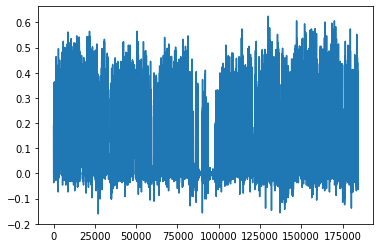

In [24]:
# Speed
speed_arr = img_VS.EyeZ.diff()/img_VS.HarpTime.diff()
speed_arr[0] = 0
plt.plot(speed_arr)

In [25]:
# Select which rois to visualize 
which_rois = np.arange(f_cells.shape[0])[iscell][:20]

In [31]:
# For each neuron, for each trial, plot raw trace with time for three depths


def plot_rois_dff_perTrial(which_rois, dffs, speed_arr, depth_list, plot_dir, plot_fname='ROIs_dff.pdf', total_plot_col=5, scale_speed=1, colors=['orange','forestgreen','skyblue'], frame_rate=30):
    trial_nums = []
    for idepth in range(0,len(depth_list)):
        depth = depth_list[idepth]
        frame_dict = stim_idx_dict['stim'+str(depth)]
        trial_nums.append(len(frame_dict['start']))
    trial_nums = np.array(trial_nums)
    if np.all(trial_nums==trial_nums[0]):
        print('Checked all trial nums are the same')
    else:
        print('Trials nums are not the same. Take the min trial num.')
    trial_num = np.min(trial_nums)

    total_trial_num = trial_num * len(depth_list)
    total_plot_row = total_trial_num/total_plot_col
    
    
    speed_arr = (speed_arr-np.mean(speed_arr))/(np.max(speed_arr)-np.min(speed_arr))*scale_speed


    
    with PdfPages(plot_dir + plot_fname) as pdf:
        for iroi in range(0,len(which_rois)):
            plt.figure(iroi, figsize=(3*total_plot_col, 3*total_plot_row))

            roi = which_rois[iroi]
            dff_max = np.max(dffs[roi,:])
            dff_min = np.min(dffs[roi,:])

            for itrial in range(0, trial_num):
                plt.subplot(int(total_plot_row),int(total_plot_col),int(itrial+1))
                plt.ylim([dff_min,np.max(speed_arr)+dff_max*1.2])


                for idepth in range(0,len(depth_list)):

                    depth = depth_list[idepth]

                    frame_start = stim_idx_dict['stim'+str(depth)]['start'][itrial]
                    frame_stop = stim_idx_dict['stim'+str(depth)]['stop'][itrial] 
                    frame_range = frame_stop - frame_start
                    dff = dffs[roi, frame_start:frame_stop]
                    speed = speed_arr[frame_start:frame_stop]
                    #plt.plot(np.arange(frame_dict['start'][itrial],frame_dict['stop'][itrial],1),dff,label='Depth = '+str(depth) + 'm',linewidth=0.5)
                    plt.plot((np.arange(frame_start,frame_stop,1)-frame_start)/frame_rate,dff,label='Depth = '+str(depth) + 'm', linewidth=0.5, c=colors[idepth])
                    plt.plot((np.arange(frame_start,frame_stop,1)-frame_start)/frame_rate,speed+dff_max*1.2, linewidth=0.5, c=colors[idepth])

                if (itrial+1)==total_plot_col:
                    plt.legend(bbox_to_anchor=(0.8, 1.2, 0.2, 0.2))

                if itrial == 0:
                    plt.title('Roi'+str(iroi), fontsize=20)
        #             plt.text((frame_start-frame_stop)/2/frame_rate,(dff_max+dff_min)/2,'Roi'+str(iroi),ha='center',fontsize=20)


            pdf.savefig()
            print('Done saving ROI: '+str(iroi))
            plt.close()

        
        
plot_rois_dff_perTrial(which_rois, dffs, speed_arr, depth_list, plot_dir=analysis_folder, plot_fname='ROIs_dff_perTrial.pdf', total_plot_col=5, scale_speed=1, colors=['orange','forestgreen','skyblue'], frame_rate=30)
       
        

Checked all trial nums are the same
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19


In [32]:
# For each neuron, for each depth, plot raw trace with time for all trials 
which_rois = which_rois
dff = dffs
depth_list = depth_list
plot_dir = analysis_folder
plot_fname='ROIs_dff_allTrials.pdf'
total_plot_col=2
colors=['orange','forestgreen','skyblue']
frame_rate=30
trial_y_space_prop = 0.5
lw = 0.2
fontsize=5


trial_nums = []
for idepth in range(0,len(depth_list)):
    depth = depth_list[idepth]
    frame_dict = stim_idx_dict['stim'+str(depth)]
    trial_nums.append(len(frame_dict['start']))
trial_nums = np.array(trial_nums)
if np.all(trial_nums==trial_nums[0]):
    print('Checked all trial nums are the same')
else:
    print('Trials nums are not the same. Take the min trial num.')
trial_num = np.min(trial_nums)
total_plot_row = len(depth_list)

# normalize dffs and speed_arr
dffs_max = np.max(dffs[which_rois],axis=1)
dffs_min = np.min(dffs[which_rois],axis=1)
each_trial_y_range = np.max(dffs_max-dffs_min)
dffs = dffs/each_trial_y_range*trial_y_space_prop

speed_arr = speed_arr/(np.max(speed_arr)-np.min(speed_arr))*trial_y_space_prop


with PdfPages(plot_dir + plot_fname) as pdf:
    for iroi in range(0,len(which_rois)):
        plt.figure(iroi, figsize=(7*total_plot_col/3, total_plot_row*trial_num/5))

        roi = which_rois[iroi]
        trial_y_space = 1 * trial_y_space_prop


        for itrial in range(0, trial_num):
            for idepth in range(0,len(depth_list)):
                plt.subplot(int(total_plot_row),int(total_plot_col),1)
                depth = depth_list[idepth]
                frame_start = stim_idx_dict['stim'+str(depth)]['start'][itrial]
                frame_stop = stim_idx_dict['stim'+str(depth)]['stop'][itrial] 
                frame_range = frame_stop - frame_start
                dff = dffs[roi, frame_start:frame_stop]
                time_series = (np.arange(frame_start,frame_stop,1)-frame_start)/frame_rate
                plt.plot(time_series,(dff-trial_y_space*itrial)/trial_y_space_prop,label='Depth = '+str(depth) + 'm', linewidth=lw, c=colors[idepth])
                plt.text((frame_stop-frame_start)/2/frame_rate,1,'Roi'+str(iroi)+ ' dFF',ha='center',fontsize=fontsize)
                plt.yticks([])
                
                plt.subplot(int(total_plot_row),int(total_plot_col),2)
                speed = speed_arr[frame_start:frame_stop]
                plt.plot(time_series,(speed-trial_y_space*itrial)/trial_y_space_prop,label='Depth = '+str(depth) + 'm', linewidth=lw, c=colors[idepth])
                plt.text((frame_stop-frame_start)/2/frame_rate,1,'Roi'+str(iroi)+ ' Speed',ha='center',fontsize=fontsize)
                if itrial ==0:
                    plt.legend(bbox_to_anchor=(0.8, 0.8, 0.2, 0.2),fontsize=fontsize/2) 
                plt.yticks([])
                    
        pdf.savefig()
        print('Done saving ROI: '+str(iroi))
        plt.close()


Checked all trial nums are the same
Done saving ROI: 0
Done saving ROI: 1
Done saving ROI: 2
Done saving ROI: 3
Done saving ROI: 4
Done saving ROI: 5
Done saving ROI: 6
Done saving ROI: 7
Done saving ROI: 8
Done saving ROI: 9
Done saving ROI: 10
Done saving ROI: 11
Done saving ROI: 12
Done saving ROI: 13
Done saving ROI: 14
Done saving ROI: 15
Done saving ROI: 16
Done saving ROI: 17
Done saving ROI: 18
Done saving ROI: 19
